TIme Series Forecast with NBeats on the Vierlinden dataset (all sensors, 2021)

In [1]:
import sys
sys.path.append('./pytorch-forecasting/')
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, TQDMProgressBar, StochasticWeightAveraging
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder

### Load data

Split in train and validation

In [2]:
# Read the dataset into a DataFrame
data = pd.read_csv('./RIWWER/Vierlinden/Vierlinden_2021_All.csv')

# Drop columns that have lots of missing values
data.drop(["FLP_Hohenstand_Pumpensumpf_pval","FLP_Strom_P3_pval","FLP_Strom_P4_pval","FLP_Strom_P5_pval","Durchfluss SWP1 und SWP2_pval","FLP_Hohenstand_Becken1_pval","FLP_Hohenstand_Becken3_pval","FLP_Hohenstand_Beckne2_pval"], axis=1, inplace=True)

# NaNs are not allowed by the model
#data.fillna(0.0, inplace=True)
data.fillna(method="bfill", inplace=True)

# Rescale all columns (Min-Max)
df = data.drop('Datetime', axis=1)
df = (df-df.min())/(df.max()-df.min())
data = pd.concat((data.Datetime, df), axis=1)

# Set Datetime as index
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [3]:
# One time series for every month?
#data['series'] = data['Datetime'].dt.year*12 + data['Datetime'].dt.month
#data['series'] -= data['series'].min()

# One time series for every 5 days?
#data['series'] = pd.Series([h for h in range(73) for _ in range(24*5)])

# One time series for the whole year?
data['series'] = 0

# As many timesteps per timeseries as hours in every month?
time_idx = []
for i in range(1):
    timesteps = len( data[ data['series'] == i ] )
    time_idx += list(range(timesteps))
data['time_idx'] = time_idx
data

,Datetime,Schieber Position_pval,Oberwasser_pval,Unterwasser_pval,Durchflumenge_pval,Berechnete Durchflussmenge_pval,Fllstand SWS_pval,Fllstand RWS_pval,Strom P1_pval,Strom P2_pval,...,Strom Pumpe 2_pval1,Strom Pumpe 3_pval,Niederschlag,Füllstand_RRB,Entleerung_RüB,Füllstand_RüB_1,Füllstand_RüB_2,Füllstand_RüB_3,series,time_idx
0,2021-01-01 00:00:00,1.000000,0.013484,0.039351,0.008396,0.007552,0.290363,0.499195,0.125956,0.0,...,0.0,0.0,0.000000,0.259259,0.001084,0.534687,0.520270,0.459459,0,0
1,2021-01-01 01:00:00,1.000000,0.012879,0.033604,0.007434,0.008240,0.290363,0.499195,0.125956,0.0,...,0.0,0.0,0.017987,0.259259,0.001096,0.534687,0.520270,0.459459,0,1
2,2021-01-01 02:00:00,1.000000,0.012741,0.031879,0.006347,0.006869,0.290363,0.499195,0.125956,0.0,...,0.0,0.0,0.017987,0.259259,0.001062,0.534687,0.520270,0.459459,0,2
3,2021-01-01 03:00:00,1.000000,0.008916,0.030330,0.004604,0.003736,0.290363,0.499195,0.125956,0.0,...,0.0,0.0,0.017987,0.259259,0.001084,0.534687,0.520270,0.459459,0,3
4,2021-01-01 04:00:00,1.000000,0.014875,0.036506,0.009155,0.008308,0.290363,0.499195,0.125956,0.0,...,0.0,0.0,0.017987,0.259259,0.001084,0.534687,0.520270,0.459459,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31 19:00:00,0.979592,0.020861,0.043257,0.010206,0.014020,0.282904,0.465915,0.198830,0.0,...,0.0,0.0,NaN,0.186949,0.002003,0.194585,0.217905,0.104730,0,8755
8756,2021-12-31 20:00:00,0.979592,0.017649,0.040044,0.008703,0.011992,0.293436,0.465915,0.152047,0.0,...,0.0,0.0,NaN,0.186949,0.001981,0.194585,0.217905,0.104730,0,8756
8757,2021-12-31 21:00:00,0.979592,0.028561,0.057103,0.018349,0.020406,0.274369,0.465915,0.187135,0.0,...,0.0,0.0,NaN,0.186949,0.002025,0.194585,0.217905,0.104730,0,8757
8758,2021-12-31 22:00:00,0.979592,0.014331,0.034731,0.007761,0.010292,0.295615,0.465915,0.144250,0.0,...,0.0,0.0,NaN,0.186949,0.002058,0.194585,0.217905,0.104730,0,8758


In [4]:
# Create dataloaders
max_encoder_length = 24*2
max_prediction_length = 5*2
#training_cutoff = data["time_idx"].max() - max_prediction_length #20*max_prediction_length
training_cutoff = data["time_idx"].max() * 4 // 5 # 80% for training
# Note: if you just subtract 1*max_prediction_length, some of the time series (for some of the months) will not be computed

context_length = max_encoder_length
prediction_length = max_prediction_length

# Note: NBeats can only handle one target
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Entleerung_RüB",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Entleerung_RüB"],
    max_encoder_length=context_length,
    min_encoder_length=max_encoder_length,
    max_prediction_length=prediction_length,
    min_prediction_length=max_prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 32#64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=36)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=36)

### Training

In [5]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="gpu",
                     devices = 1,
                     max_epochs = 20,
                     gradient_clip_val=0.01,
                     logger = False)
net = NBeats.from_dataset(training,
                          learning_rate=3e-2, weight_decay=1e-2,
                          widths=[32, 512], backcast_loss_ratio=1.0)
# Note: 'widths' denotes the width of each forecasting block. By default, the first forecasts the trend, while the second forecasts seasonality.

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/mnt/KInsektDaten/teo/./pytorch-forecasting/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00014125375446227546
Restoring states from the checkpoint path at /mnt/KInsektDaten/teo/.lr_find_deee08d3-b8e9-41d5-aa97-71eef121c0f9.ckpt
Restored all states from the checkpoint at /mnt/KInsektDaten/teo/.lr_find_deee08d3-b8e9-41d5-aa97-71eef121c0f9.ckpt


suggested learning rate: 0.00014125375446227546


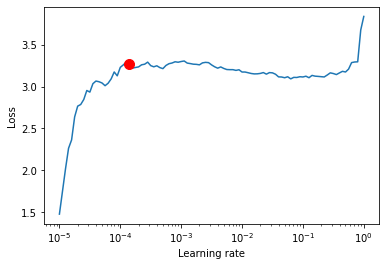

In [6]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net,
                             train_dataloaders=train_dataloader,
                             val_dataloaders=val_dataloader,
                             min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model

In [7]:
pl.seed_everything(42)
early_stop = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_sched = StochasticWeightAveraging(swa_lrs=res.suggestion(), swa_epoch_start=5, device=torch.device('cuda:0'))
lr_logger = LearningRateMonitor(logging_interval='step')  # log the learning rate ('step' or 'epoch')
logger = TensorBoardLogger("./RIWWER/torch_forecasting/model_checkpoints/NBeats_Vierlinden")  # logging results to a tensorboard
# at this path, a folder with the name lightning_logs is searched for; if not found, it is created

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop, lr_logger, TQDMProgressBar(), lr_sched],
    limit_train_batches=150,
    log_every_n_steps=5,
    logger=logger
)

net = NBeats.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
# best loss: 2.376 (with default loss)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss         

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.366


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.282 >= min_delta = 0.0001. New best score: 3.084


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.193 >= min_delta = 0.0001. New best score: 2.890


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.151 >= min_delta = 0.0001. New best score: 2.739
Swapping scheduler `ReduceLROnPlateau` for `SWALR`


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.104 >= min_delta = 0.0001. New best score: 2.635


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.0001. New best score: 2.583


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0001. New best score: 2.530


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.0001. New best score: 2.484


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0001. New best score: 2.465


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.464


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0001. New best score: 2.437


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.431


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0001. New best score: 2.399


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 2.382


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.381


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.376


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 2.376. Signaling Trainer to stop.


### Evaluation

In [8]:
trainer.callback_metrics

{'train_loss': tensor(2.3147),
 'train_loss_step': tensor(3.0829),
 'train_backcast_loss': tensor(0.3653),
 'train_backcast_loss_step': tensor(0.4195),
 'train_forecast_loss': tensor(2.3147),
 'train_forecast_loss_step': tensor(3.0829),
 'val_backcast_loss': tensor(0.3420),
 'val_forecast_loss': tensor(2.3845),
 'val_loss': tensor(2.3845),
 'val_SMAPE': tensor(0.4820),
 'val_MAE': tensor(0.0144),
 'val_RMSE': tensor(0.0347),
 'val_MAPE': tensor(6522.6123),
 'val_MASE': tensor(2.3845),
 'train_loss_epoch': tensor(2.3147),
 'train_backcast_loss_epoch': tensor(0.3653),
 'train_forecast_loss_epoch': tensor(2.3147)}

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = NBeats.load_from_checkpoint(best_model_path)

./RIWWER/torch_forecasting/model_checkpoints/NBeats_Vierlinden/lightning_logs/version_10/checkpoints/epoch=41-step=6300.ckpt


In [10]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0')) # actuals were on CPU per default
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NBeats_Vierlinden"))
(actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.0144, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


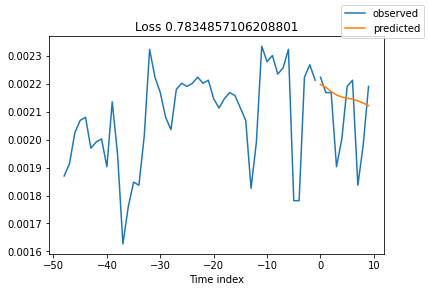

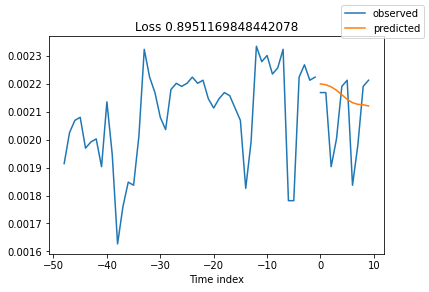

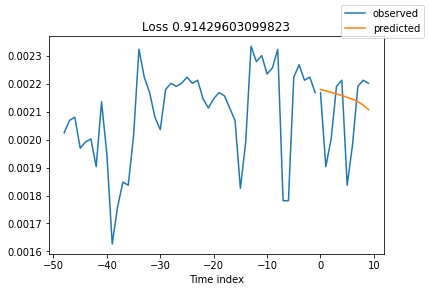

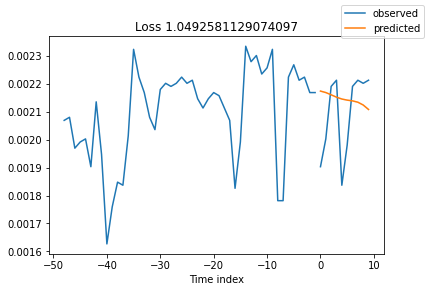

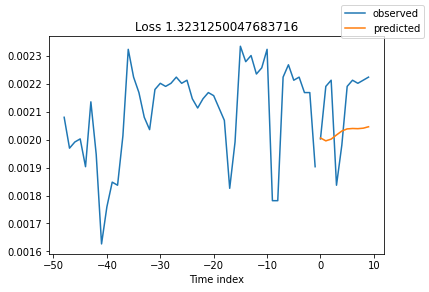

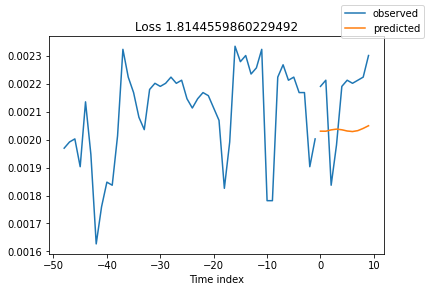

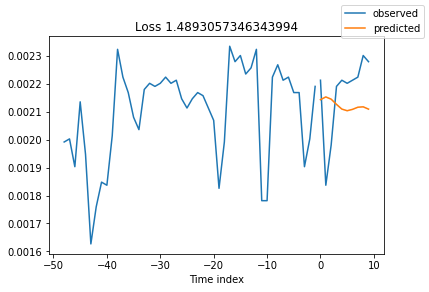

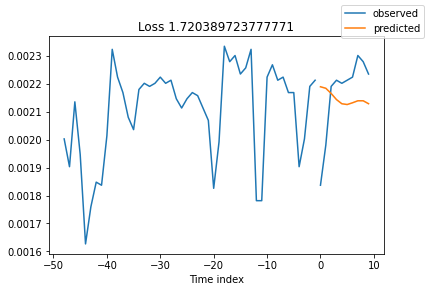

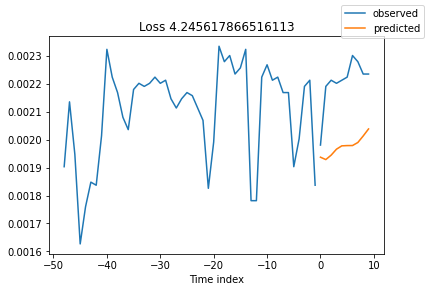

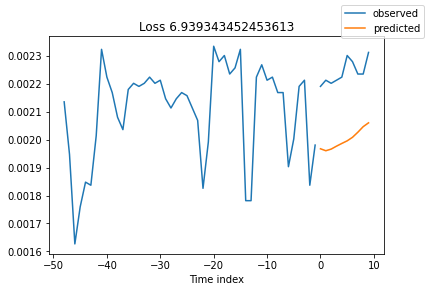

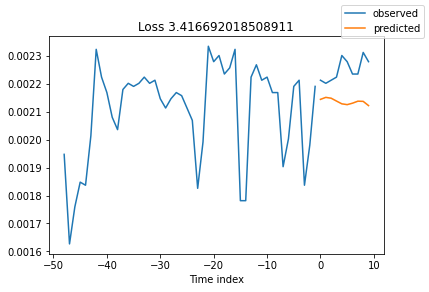

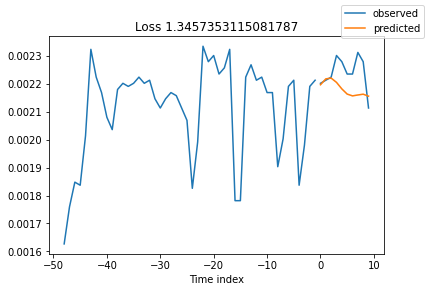

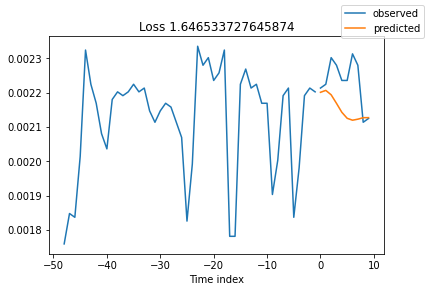

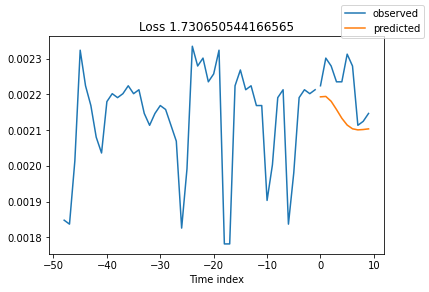

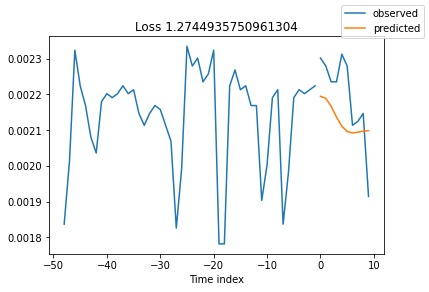

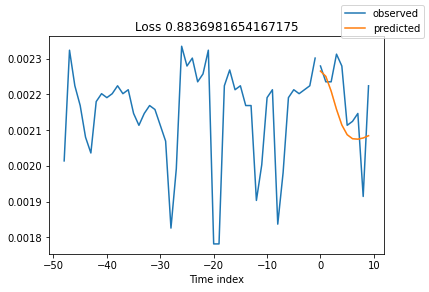

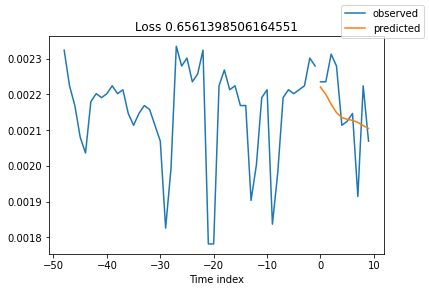

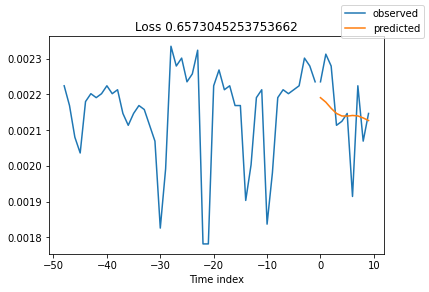

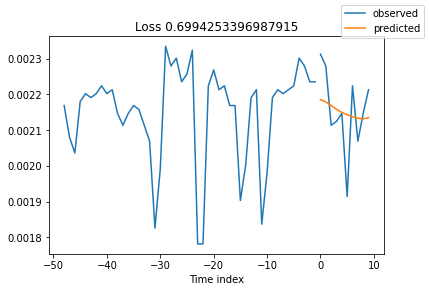

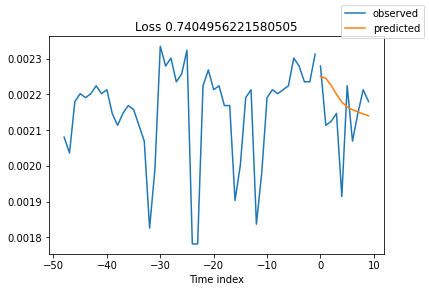

In [11]:
# Some random samples from the val. set
raw_predictions = best_model.predict(val_dataloader, mode="raw",
                                     return_x=True,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NBeats_Vierlinden"))
for idx in range(20):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                               idx=idx, add_loss_to_title=True)

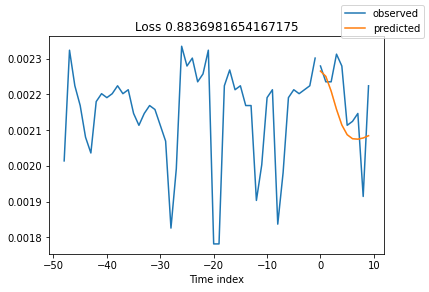

In [22]:
fig = best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                           idx=15, add_loss_to_title=True)

#### Interpretation

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Traceback (most recent call last):
  File "/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/shutil.py", line 738, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/shutil.py", line 736, in rmtree
    o

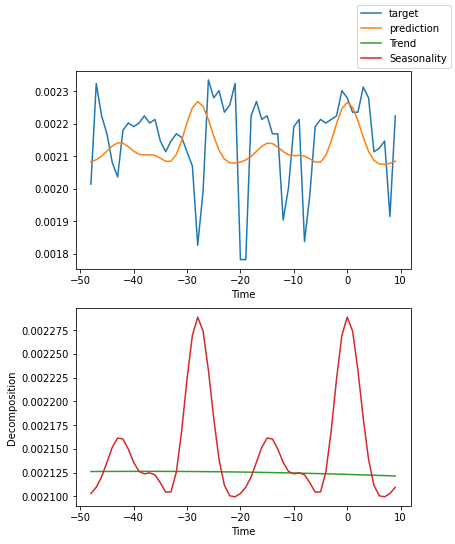

In [7]:
fig = best_model.plot_interpretation(raw_predictions.x,
                                     raw_predictions.output, idx=15)

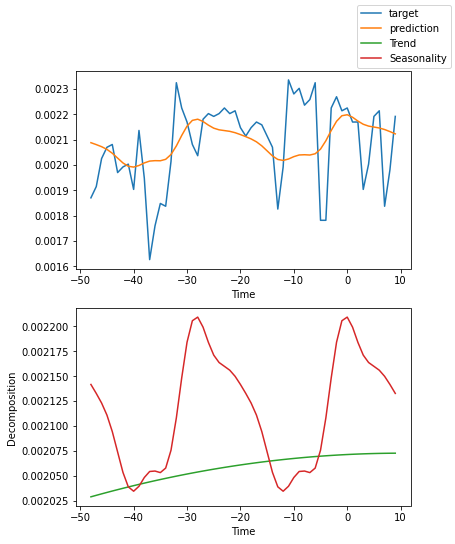

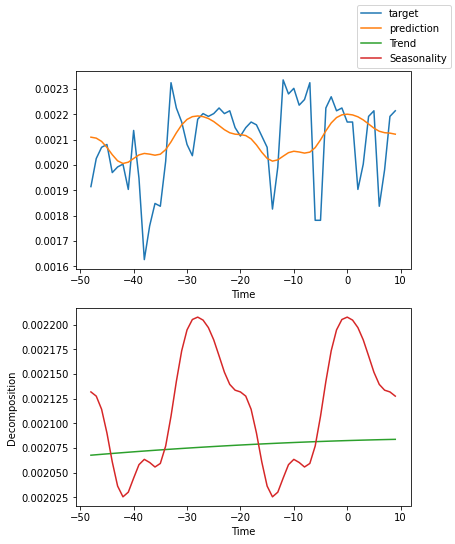

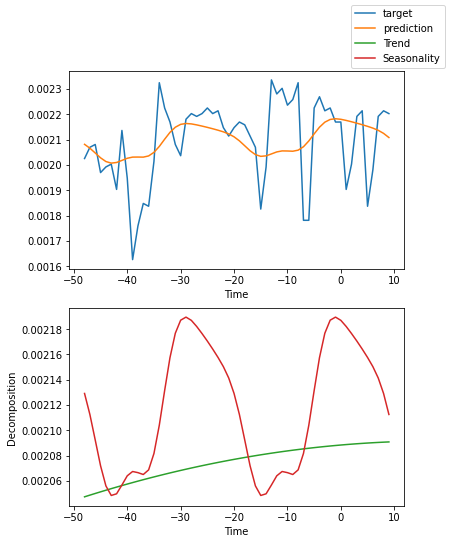

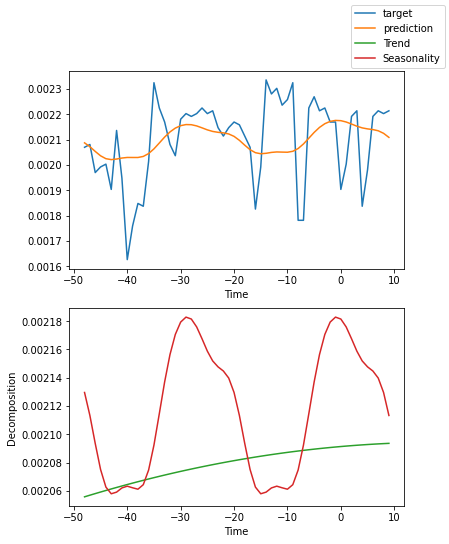

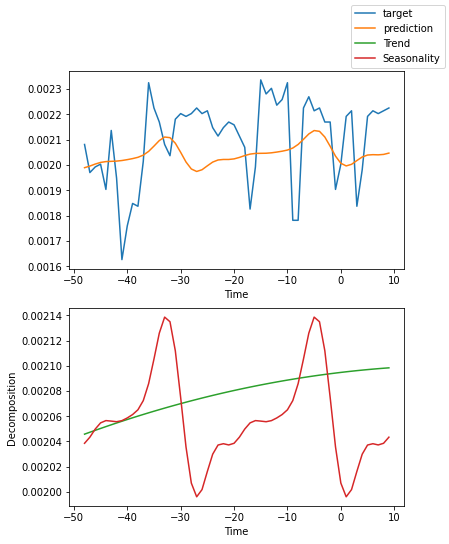

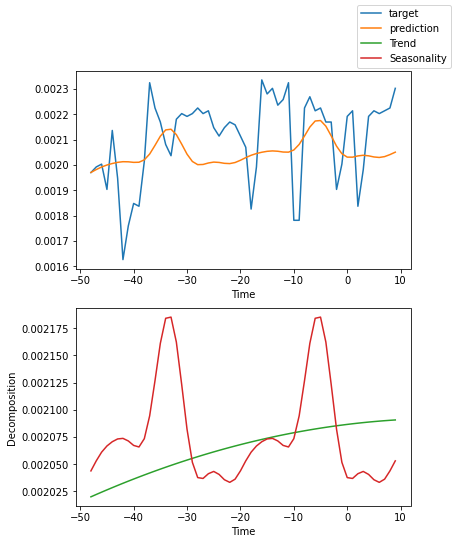

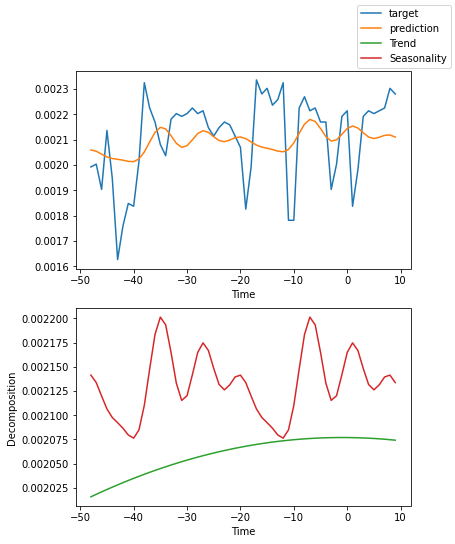

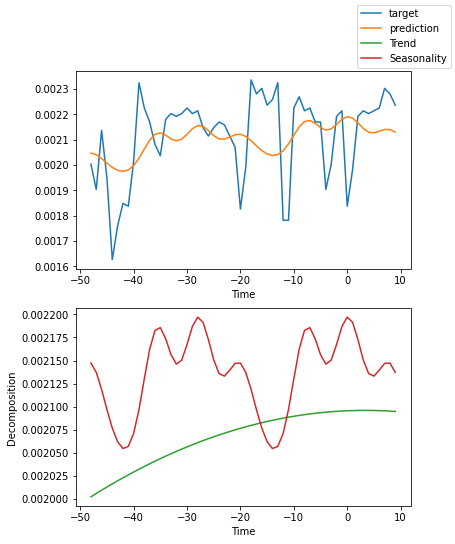

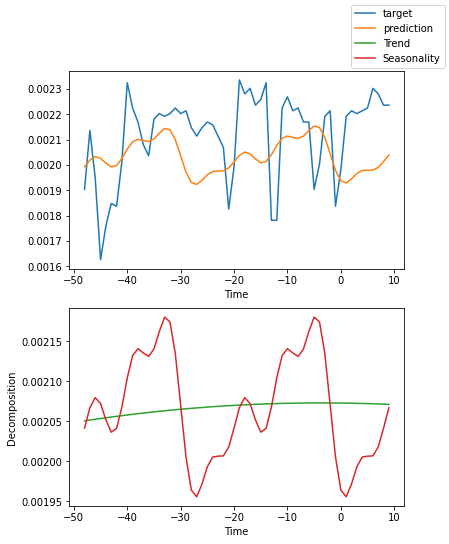

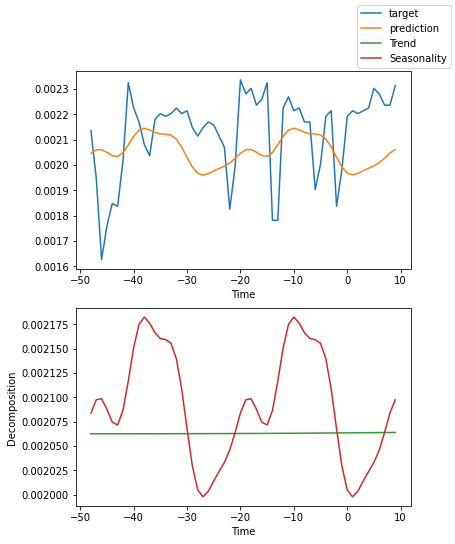

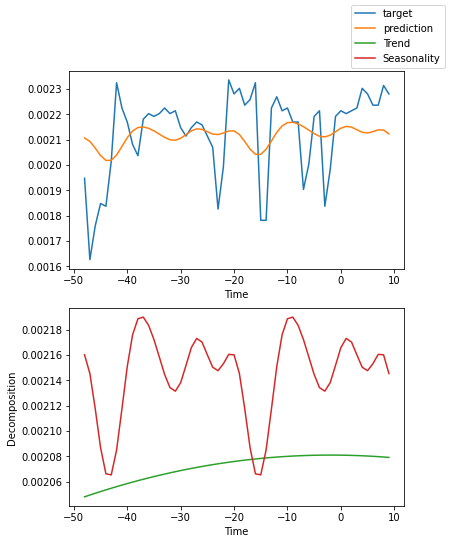

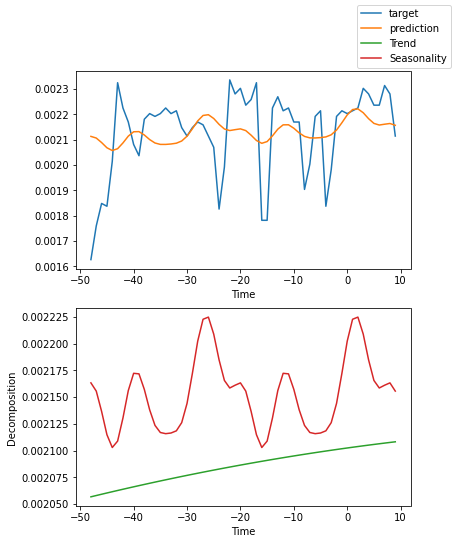

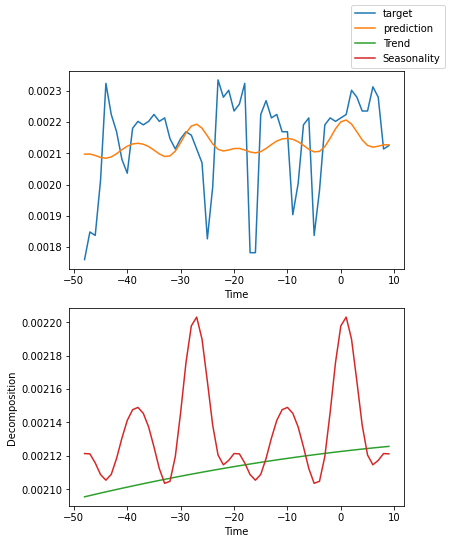

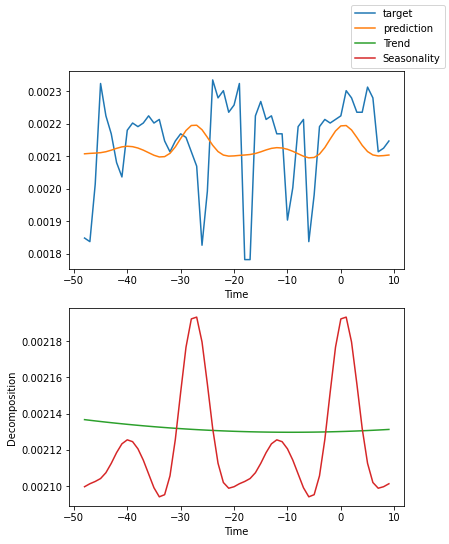

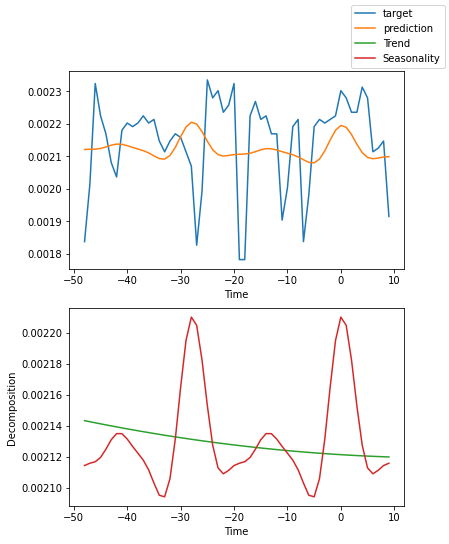

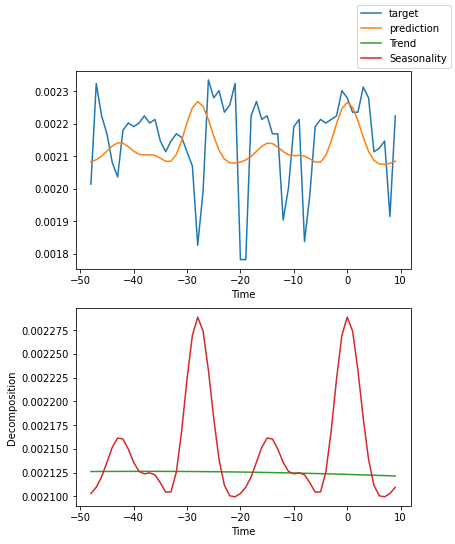

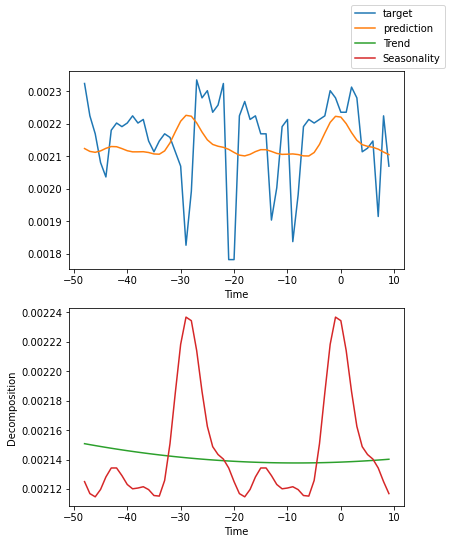

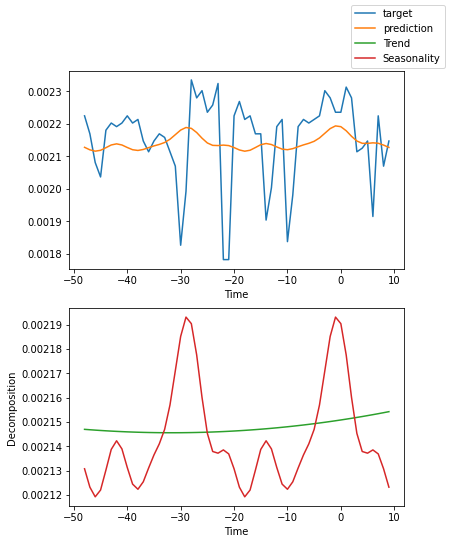

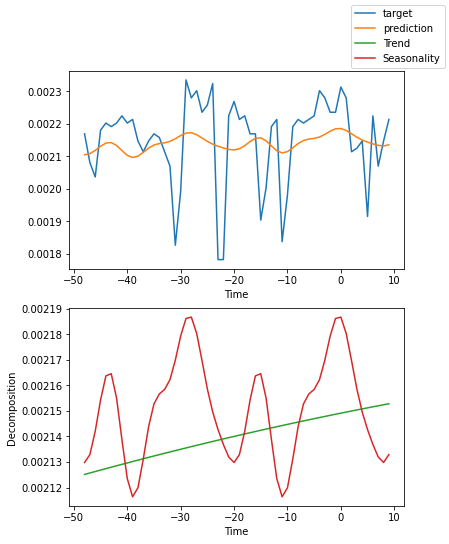

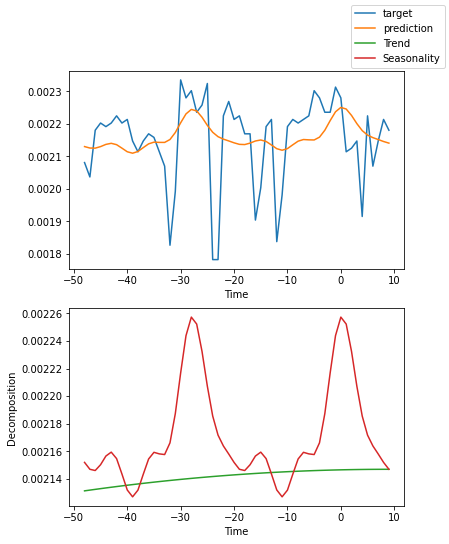

In [12]:
for idx in range(20):
    best_model.plot_interpretation(raw_predictions.x,
                                   raw_predictions.output,
                                   idx=idx)